# Salary Prediction from LinkedIn Job Postings - Evaluate Stats Model

In [1]:
import pandas as pd, numpy as np
import salary
from sklearn.base import BaseEstimator

/var/folders/vm/77wrgjgj5wzbyghx353b7gym0000gn/T/ipykernel_39803/830439244.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd, numpy as np
/Users/nginyc/repos/job_posting_salary_prediction/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Evaluate Mean & Median by Norm Title Models

In [2]:
(X_train, y_train) = salary.get_train_dataset()
(X_test, y_test) = salary.get_test_dataset()

In [3]:
class MeanSalaryEstimator(BaseEstimator):
    def fit(self, X: pd.DataFrame, y):
        Xy = X.copy()
        Xy['salary'] = y
        self._salaries_by_title = Xy.groupby('norm_title')['salary'].mean()
        self._global_salary = Xy['salary'].mean()
        return self
    
    def predict(self, X):
        return np.array([
            self._salaries_by_title.loc[title] if title in self._salaries_by_title.index else self._global_salary
            for title in X['norm_title']
        ])

model = MeanSalaryEstimator().fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_model_result = salary.evaluate_test_predictions(y_pred)

Test R2: 0.1973
Test RMSE: 52230.7979
Test MAE: 36058.6326


In [4]:
class MedianSalaryEstimator(BaseEstimator):
    def fit(self, X: pd.DataFrame, y):
        Xy = X.copy()
        Xy['salary'] = y
        self._salaries_by_title = Xy.groupby('norm_title')['salary'].median()
        self._global_salary = Xy['salary'].median()
        return self
    
    def predict(self, X):
        return np.array([
            self._salaries_by_title.loc[title] if title in self._salaries_by_title.index else self._global_salary
            for title in X['norm_title']
        ])
    
model = MedianSalaryEstimator().fit(X_train, y_train)
y_pred = model.predict(X_test)
median_model_result = salary.evaluate_test_predictions(y_pred)

Test R2: 0.1472
Test RMSE: 53838.0820
Test MAE: 34647.9510


/Users/nginyc/repos/job_posting_salary_prediction/salary.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Test R²', data=metrics_df, ax=axes[0], palette='Blues')
/Users/nginyc/repos/job_posting_salary_prediction/salary.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
/Users/nginyc/repos/job_posting_salary_prediction/salary.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Test RMSE', data=metrics_df, ax=axes[1], palette='Greens')
/Users/nginyc/repos/job_posting_salary_prediction/salary.py:11

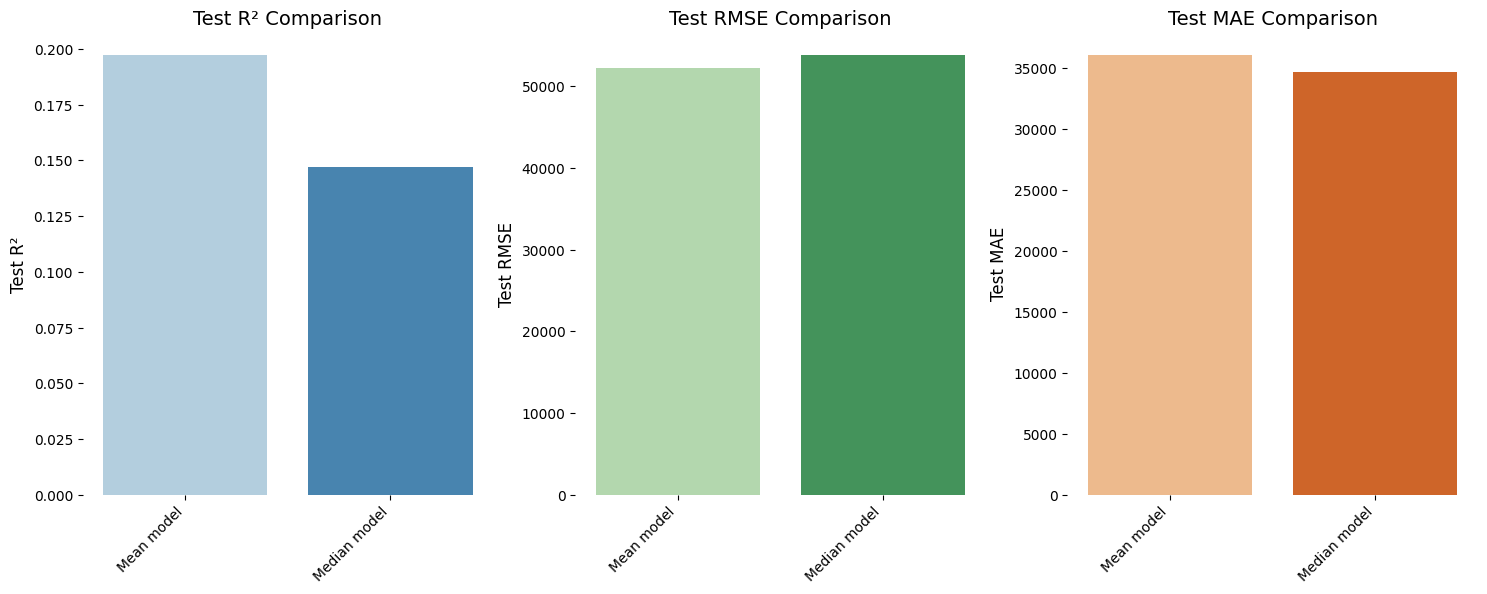

In [5]:
salary.plot_evaluation_results(['Mean model', 'Median model'], [mean_model_result, median_model_result])